# Import Libraries

In [15]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [16]:
train_transforms = A.Compose([
    #A.Resize(32, 32),
    A.ShiftScaleRotate(shift_limit = 0.2, scale_limit = 0.1, rotate_limit = 15,p=0.4),
    A.HorizontalFlip(),
    A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.4, hue=0.2, always_apply=False, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, fill_value=0, mask_fill_value=None, always_apply=False, p=0.3),
    A.Normalize (mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ToTensorV2()
])

# Test Phase transformations
test_transforms = A.Compose([
                             ToTensorV2(),
                             A.Normalize (mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
                                       ])

test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                       ])

def apply_transform_train(image):
    return train_transforms(image=np.array(image))

def apply_transform_test(image):
    return test_transforms(image=np.array(image))

# Dataset and Creating Train/Test Split

In [4]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=apply_transform_train)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 12983838.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 2

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data,**args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# Shape of the train data
print (train_data.data.shape)
# Shape of the test data
print (test_data.data.shape)

# Number of categories in the data
print (len(train_data.classes))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
10


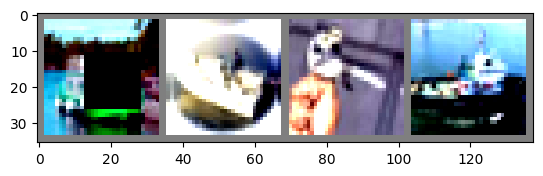

ship  ship  bird  ship 


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images['image'][:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [37]:
dropout_value = 0.1
class Model_CFAR(nn.Module):
    def __init__(self):
        super(Model_CFAR, self).__init__()

        # *******************************Conv Block 1*************************
        # Block1-Layer1
        self.convblk1_ly1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

        # Block1-Layer2
        self.convblk1_ly2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=2,  bias=False,dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

        # Block1 - TB
        self.convblk1_tb = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=30, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=30, out_channels=30, kernel_size=(3, 3), padding=0,stride=2, bias=False),
            nn.ReLU())
        # ****************************Conv Block 2****************************
        # Block 2 - Layer1 - Depthwise
        self.convblk2_ly1 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=30, kernel_size=(3, 3), padding=1, bias=False,groups=30),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=30, out_channels=64, kernel_size=(1, 1), padding=0, bias=False))

         #Block 2- Layer2
        self.convblk2_ly2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=2, bias=False,dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

        # Block 2 - TB - Using Dilated Conv Layer in place of strided conv
        self.convblk2_tb = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=30, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=30, out_channels=30, kernel_size=(3, 3), padding=0,stride=1,dilation=3, bias=False),
            nn.ReLU())
        # ****************************Conv Block 3****************************
        # Block 3 - Layer 1

        self.convblk3_ly1 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

        #Block 3 - Layer 2
        self.convblk3_ly2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=2, bias=False,dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

        # Block 3- TB
        self.convblk3_tb = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=30, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=30, out_channels=30, kernel_size=(3, 3), padding=1,stride=2, dilation=1, bias=False),
            nn.BatchNorm2d(30),
            nn.ReLU())
        # ****************************Conv Block 4****************************
        # Block 4 - Layer 1

        self.convblk4_ly1 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=35, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(35),
            nn.Dropout(dropout_value))

        #Block 4 - Layer 2
        self.convblk4_ly2 = nn.Sequential(
            nn.Conv2d(in_channels=35, out_channels=35, kernel_size=(3, 3), padding=2, bias=False,dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(35),
            nn.Dropout(dropout_value))

        # Block 4- Layer 3
        self.convblk4_ly3 = nn.Sequential(
            nn.Conv2d(in_channels=35, out_channels=44, kernel_size=(3, 3), padding=1,stride=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(44))
        #****************************Output Block*************************
        # GAP Layer
        self.gap = nn.AdaptiveAvgPool2d(1)

       # FC Layer
        self.fc = nn.Linear(44, 10,bias=False)

    def forward(self, x):
        x = self.convblk1_ly1(x)
        x = x+self.convblk1_ly2(x)
        x = self.convblk1_tb(x)
        x = self.convblk2_ly1(x)
        x = x+self.convblk2_ly2(x)
        x = self.convblk2_tb(x)
        x = self.convblk3_ly1(x)
        x = x+self.convblk3_ly2(x)
        x = self.convblk3_tb(x)
        x = self.convblk4_ly1(x)
        x = x+self.convblk4_ly2(x)
        x = self.convblk4_ly3(x)
        x = self.gap(x)
        x = x.view(-1, 1*1*44)
        x = self.fc(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [38]:
x = torch.randn(1,64,11,11)
model=Model_CFAR()
for layer in model.convblk2_tb:
  x = layer(x)
  print (layer)
  print(x.size())

Conv2d(64, 30, kernel_size=(1, 1), stride=(1, 1), bias=False)
torch.Size([1, 30, 11, 11])
Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), dilation=(3, 3), bias=False)
torch.Size([1, 30, 5, 5])
ReLU()
torch.Size([1, 30, 5, 5])


In [39]:
# Model Summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_CFAR().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,728
              ReLU-2           [-1, 64, 30, 30]               0
       BatchNorm2d-3           [-1, 64, 30, 30]             128
           Dropout-4           [-1, 64, 30, 30]               0
            Conv2d-5           [-1, 64, 30, 30]          36,864
              ReLU-6           [-1, 64, 30, 30]               0
       BatchNorm2d-7           [-1, 64, 30, 30]             128
           Dropout-8           [-1, 64, 30, 30]               0
            Conv2d-9           [-1, 30, 30, 30]           1,920
           Conv2d-10           [-1, 30, 14, 14]           8,100
             ReLU-11           [-1, 30, 14, 14]               0
           Conv2d-12           [-1, 30, 14, 14]             270
             ReLU-13           [-1, 30, 14, 14]               0
      BatchNorm2d-14           [-1

In [11]:
# Training And Testing

In [40]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data_aug, target = data['image'].to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data_aug)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data_aug)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss


In [ ]:
#@title
from torch.optim.lr_scheduler import StepLR,OneCycleLR
model =  Model_CFAR().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)
#scheduler = OneCycleLR(optimizer, max_lr=0.01,steps_per_epoch=len(train_loader),epochs=80)
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

In [13]:

# Wrong predictions
cnt=0
import random
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True)
img_lst=[]
cat_lst=[]
x_lst=[]
for i in range(0,127):
  x = random.randint(0,127)

  if pred[x].item()!=target[x].item():
    img=data[x].cpu().numpy().T
    img_lst.append(img)
    cat=[value for key,value in enumerate(train_data.class_to_idx) if key!=target[x].item()][0]
    cat_lst.append(cat)
    x_lst.append(x)
    cnt+=1
  if cnt>9:
    break

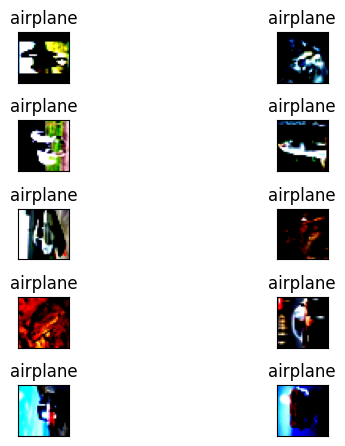

In [14]:
for i in range(10):
  plt.subplot(5,2,i+1)
  plt.tight_layout()
  plt.imshow(img_lst[i])
  plt.title(cat_lst[i])
  plt.xticks([])
  plt.yticks([])